In [4]:
from astropy.io import fits
from scipy.signal import fftconvolve
import numpy as np
import seaborn as sns
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt

In [5]:
sns.set(rc={'figure.figsize': (50, 50)})
%matplotlib inline

In [6]:
test_set = "/scratch/datasets/astro_deconv_2019/test/"
indexes=list(range(5000, 105000, 5000))

In [7]:
test_start = 9400
test_end = 9700

In [8]:
def open_fits(x):
    return fits.open(x)[0].data.squeeze()

def convolve(convoled, convolver):
    p = convolver.shape[0]
    r = slice(p//2, -p//2+1)    # uneven PSF needs +2, even psf +1
    return fftconvolve(convoled, convolver, mode="full")[r,r]

In [9]:
# calculate wsclean baseline
l1_wsclean = []
for number in range(test_start, test_end):
    target_path = "{}{}-skymodel.fits".format(test_set, number)
    wsclean_model_path = "{}{}-wsclean-model.fits".format(test_set, number)
    clean_beam_path = "{}{}-clean-beam.fits".format(test_set, number)
    clean_beam = open_fits(clean_beam_path)
    target = open_fits(target_path)
    wsclean_model = open_fits(wsclean_model_path)
    target_convolved = convolve(target, clean_beam)
    wsclean_convoled = convolve(wsclean_model, clean_beam)
    l1_wsclean.append(np.sum(np.abs( wsclean_model - target)))

In [10]:
wsclean_scaling = 1/ np.average(l1_wsclean)

In [11]:
def compute(neural_output, start, end):
    scores = []
    for number in range(start, end):
        target_path = "{}{}-skymodel.fits".format(test_set, number)
        neural_model_path = "{}{}-outputs.fits".format(neural_output, number)
        clean_beam_path = "{}{}-clean-beam.fits".format(test_set, number)
        clean_beam = open_fits(clean_beam_path)
        target = open_fits(target_path)
        neural_model = open_fits(neural_model_path )
        target_convoled = convolve(target, clean_beam)
        neural_convolved = convolve(neural_model, clean_beam)
        score = np.sum(np.abs( neural_convolved - target_convoled))
        scores.append(score)
    return scores

In [12]:
all_scores = {}
for type_ in ("gan", "gan_psf", "gan_psf_res"):
    for run in range(1, 11):
        steps = []
        for index in indexes:
            print(f"type: {type_} run: {run} index: {index}")
            neural_output = f"/scratch/vacuum-cleaner/final_eval_lr/{type_}/test/run{run}/{index}/fits/"
            scores = compute(neural_output, test_start, test_end)
            scaled = np.average(scores) * wsclean_scaling
            steps.append(scaled)
        all_scores[f"{type_}__run{run}"] = steps

type: gan run: 1 index: 5000


KeyboardInterrupt: 

In [13]:
from joblib import Parallel, delayed
import multiprocessing
     
def doit(neural_output, wsclean_scaling, type_, run, index):
    print(f"type: {type_} run: {run} index: {index}")
    neural_output = f"/scratch/vacuum-cleaner/final_eval_lr/{type_}/test/run{run}/{index}/fits/"
    scores = compute(neural_output, test_start, test_end)
    scaled = np.average(scores) * wsclean_scaling
    return scaled
 
num_cores = multiprocessing.cpu_count()

In [14]:
scores = {}

In [15]:
for type_ in ("gan",): #, "gan_psf", "gan_psf_res"):
    for run in range(1, 11):
        p = Parallel(n_jobs=num_cores)
        steps = p(delayed(doit)(neural_output, wsclean_scaling, type_, run, index) for index in indexes)
        scores[f"{type_}__run{run}"] = steps

In [17]:
data = pd.DataFrame(scores, index=indexes)

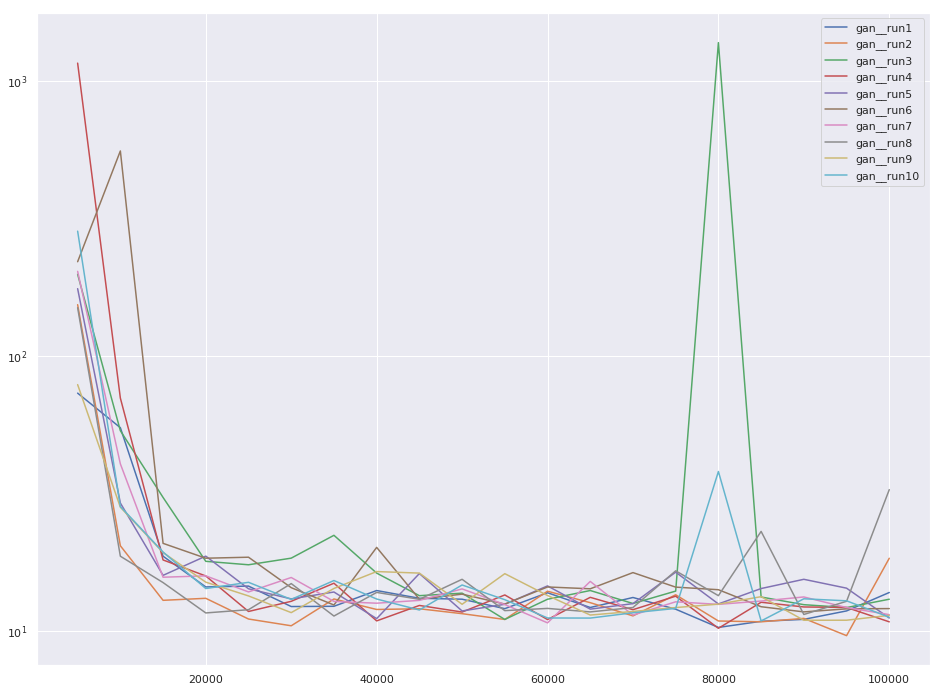

In [18]:
plt.figure(figsize=(16, 12))
p = sns.lineplot(data=data, dashes=False)
p.set_yscale('log')

In [20]:
data.mean()

gan__run1     18.073270
gan__run2     19.672784
gan__run3     94.851826
gan__run4     73.105268
gan__run5     22.767669
gan__run6     52.123612
gan__run7     24.094966
gan__run8     21.661017
gan__run9     17.481530
gan__run10    28.716340
dtype: float64

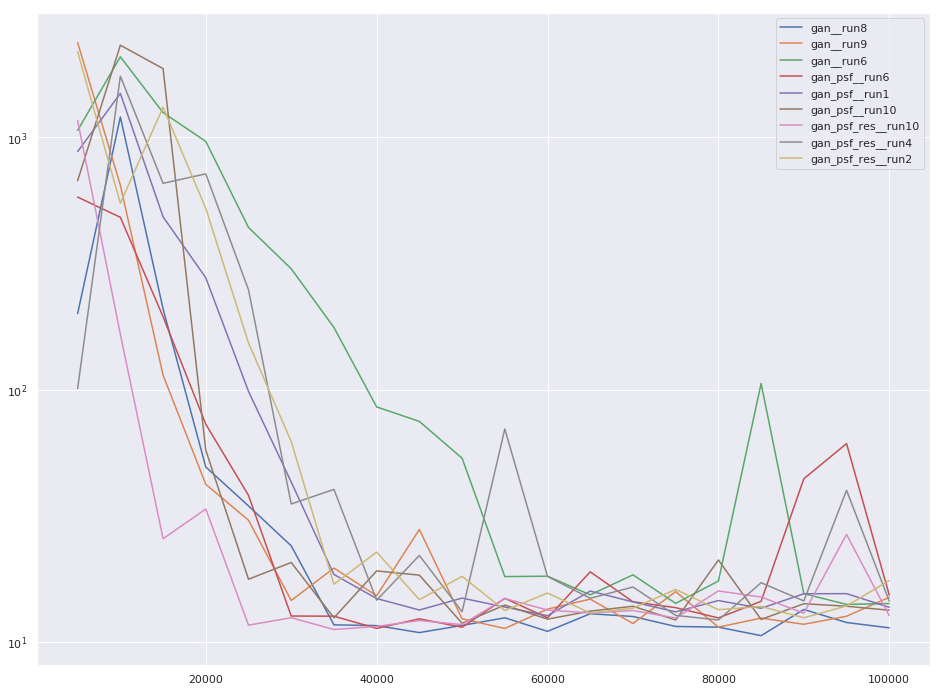

In [73]:
selection = ["gan__run8", "gan__run9", "gan__run6", "gan_psf__run6", "gan_psf__run1", "gan_psf__run10", "gan_psf_res__run10", "gan_psf_res__run4", "gan_psf_res__run2"]
plt.figure(figsize=(16, 12))
p = sns.lineplot(data=data[selection], dashes=False)
p.set_yscale('log')

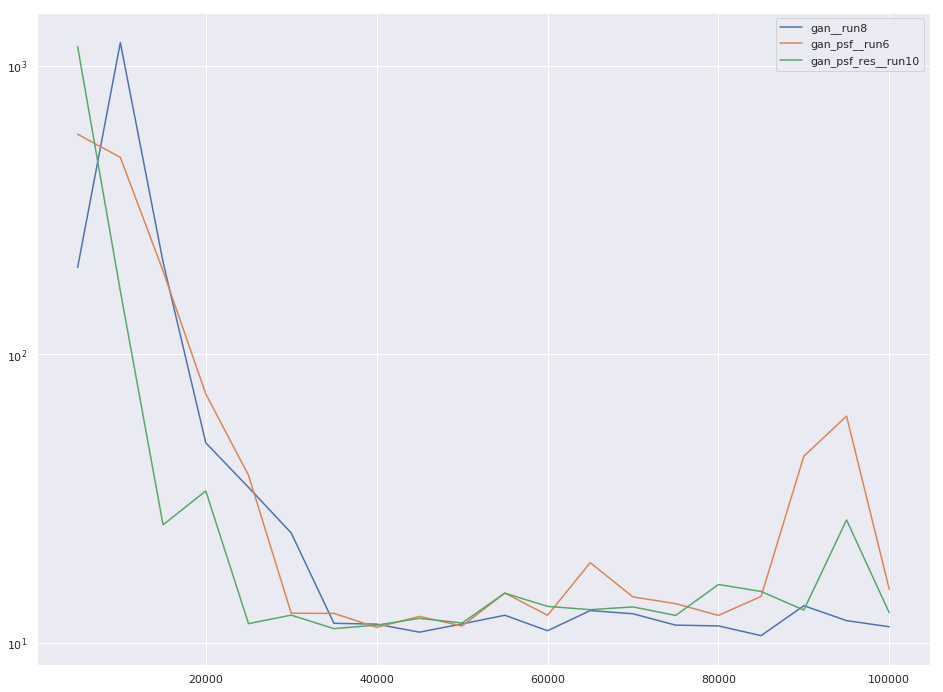

In [74]:
selection = ["gan__run8", "gan_psf__run6", "gan_psf_res__run10"]
plt.figure(figsize=(16, 12))
p = sns.lineplot(data=data[selection], dashes=False)
p.set_yscale('log')